In [123]:
!pip install trl transformers unsloth
# !pip install -U bitsandbytes

## Prepairing data

In [124]:
dataset_path = "/content/reasoning_dataset.csv"

In [125]:
import pandas as pd
from datasets import Dataset
from unsloth.chat_templates import get_chat_template, standardize_sharegpt

In [126]:
custom_file = pd.read_csv(dataset_path)
custom_file.head(n=-1 )

,productName,price,description,specifications,revews,questionsAnswers,question,answer,reason
0,saf Wooden Framed Floral theme Canvas Wall Pai...,₹ 480,[SAF Presents you the Premium Wooden Framed Ca...,"Model Number: CVS-280, Model Name: Wooden Fram...",[Quality is],No questions found!,Will the colors of this painting fade over time?,"No, the colors are designed to last for many y...",The description says it uses “modern and effic...
1,saf Wooden Framed Floral theme Canvas Wall Pai...,₹ 480,[SAF Presents you the Premium Wooden Framed Ca...,"Model Number: CVS-280, Model Name: Wooden Fram...",[Quality is],No questions found!,Is this painting ready to hang or do I need to...,It's ready to hang — it comes with a wooden fr...,The title clearly says “Wooden Framed” and th...
2,saf Wooden Framed Floral theme Canvas Wall Pai...,₹ 480,[SAF Presents you the Premium Wooden Framed Ca...,"Model Number: CVS-280, Model Name: Wooden Fram...",[Quality is],No questions found!,Can I use this in an office or is it just for ...,"Yes, it’s perfect for both home and office spa...",The product description explicitly mentions it...
3,saf Wooden Framed Floral theme Canvas Wall Pai...,₹ 480,[SAF Presents you the Premium Wooden Framed Ca...,"Model Number: CVS-280, Model Name: Wooden Fram...",[Quality is],No questions found!,Is this painting a good gift option?,"Yes, it would make a great gift.","The product description states, “Our canvas pa..."
4,Acer Aspire 3 Intel Core i3 13th Gen 1305U - (...,"₹ 30,990",No description found!,"Sales Package: Laptop, Power Adaptor, User Gui...","[I have been using this last 10 days,My Experi...","[Q: Can I play GTA 5 and Minecraft, A: Absolut...",Kya ye laptop student ke liye achha hai?,"Haan, agar aap student ho aur light tasks ke l...",One review suggests that it’s perfect for stud...
...,...,...,...,...,...,...,...,...,...
102,Crompton 88 L Desert Air Cooler with Honeycomb...,"₹ 9,999",It features a honeycomb cooling pad that offer...,No specifications found!,"[Value for money.Pros,1.Cooling effect - gives...",[Q: I bought this cooler but no water drain po...,Can the Crompton 88 L Desert Air Cooler be use...,"Yes, it is designed for large areas, efficient...",Designed for large areas and higher cooling ne...
103,Crompton 88 L Desert Air Cooler with Honeycomb...,"₹ 9,999",It features a honeycomb cooling pad that offer...,No specifications found!,"[Value for money.Pros,1.Cooling effect - gives...",[Q: I bought this cooler but no water drain po...,What are the advantages and disadvantages of t...,"Advantages include good cooling, strong air de...","""Cooling effect - gives better cooling"" (Revie..."
104,Panasonic 2025 Model 1.5 Ton 3 Star Split Inve...,"₹ 37,490",This Panasonic Smart AC comes with cutting-edg...,"In The Box: 1 Indoor Unit, 1 Outdoor Unit, Rem...",[Product is very nice and worthy but really di...,[Q: Lg 1.5 ton 6 in 1 or Panasonic 1.5 ton 7 i...,How is the cooling performance of the Panasoni...,"The cooling performance is excellent, providin...","""Cooling 5/5"" (Review) | ""Provides uniform com..."
105,Panasonic 2025 Model 1.5 Ton 3 Star Split Inve...,"₹ 37,490",This Panasonic Smart AC comes with cutting-edg...,"In The Box: 1 Indoor Unit, 1 Outdoor Unit, Rem...",[Product is very nice and worthy but really di...,[Q: Lg 1.5 ton 6 in 1 or Panasonic 1.5 ton 7 i...,Does the Panasonic AC have Wi-Fi connectivity?,"Yes, the Panasonic AC comes with Wi-Fi connect...","""Panasonic’s AI-enabled app, MirAIe"" (Descript..."


In [127]:
custom_file.columns

Index(['productName', 'price', 'description', 'specifications', 'revews',
       'questionsAnswers', 'question', 'answer', 'reason'],
      dtype='object')

In [128]:
def format_data(example):
  return [{"role": "system", "content": "You are a product related question answering assistant. Generate answer based on product's description, specifications, review and previously asked questions. Also write reason as source of your answer(input data line containg answer)/"},
          {"role": "user", "content": f"Product: {example['productName']}\nPrice: {example['price']}\nDescription: {example['description']}\nspecifications: {example['specifications']}\nReviews: {example['revews']}\nPrevious Questions: {example['questionsAnswers']}\nQuestion: {example['question']}"},
          {"role": "assistant", "content": f"Answer: {example['answer']}\nreason: {example['reason']}"}] # Format as list of dicts with role and content

custom_file["text"] = custom_file.apply(format_data, axis=1)
custom_file = custom_file[["text"]]
print(custom_file.head())
custom_dataset = Dataset.from_pandas(custom_file)
# custom_dataset = Dataset.from_pandas(custom_file)

                                                text
0  [{'role': 'system', 'content': 'You are a prod...
1  [{'role': 'system', 'content': 'You are a prod...
2  [{'role': 'system', 'content': 'You are a prod...
3  [{'role': 'system', 'content': 'You are a prod...
4  [{'role': 'system', 'content': 'You are a prod...


In [129]:
custom_dataset = standardize_sharegpt(custom_dataset)
custom_dataset["text"]

[[{'content': "You are a product related question answering assistant. Generate answer based on product's description, specifications, review and previously asked questions. Also write reason as source of your answer(input data line containg answer)/",
   'role': 'system'},
  {'content': 'Product: saf Wooden Framed Floral theme Canvas Wall Painting for Home Décor and Office Digital Reprint 16 inch x 16 inch Painting (With Frame)\nPrice: ₹ 480\nDescription: [SAF Presents you the Premium Wooden Framed Canvas Paintings!We use only the most modern and efficient printing technology on our canvases, printed on canvas material that is stretched or gallery wrapped onto a frame and displayed.This innovative hd printing technique results in durable and spectacular looking prints of the that last a lifetime. Also our canvas prints retain their beautiful colours for many years. It will Add colour and style to your living space with this digitally printed canvas painting. Liven up your place with t

In [130]:
custom_dataset = custom_dataset.map(
    lambda example: {
        "newtext": [
            tokenizer.apply_chat_template(convo, tokenize=False)
            for convo in example["text"]
        ]
    },
    batched=True,
)
custom_dataset

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'newtext'],
    num_rows: 108
})

In [131]:
custom_dataset["newtext"]

["<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 24 Apr 2025\n\nYou are a product related question answering assistant. Generate answer based on product's description, specifications, review and previously asked questions. Also write reason as source of your answer(input data line containg answer)/<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nProduct: saf Wooden Framed Floral theme Canvas Wall Painting for Home Décor and Office Digital Reprint 16 inch x 16 inch Painting (With Frame)\nPrice: ₹ 480\nDescription: [SAF Presents you the Premium Wooden Framed Canvas Paintings!We use only the most modern and efficient printing technology on our canvases, printed on canvas material that is stretched or gallery wrapped onto a frame and displayed.This innovative hd printing technique results in durable and spectacular looking prints of the that last a lifetime. Also our canvas prints retain their beautiful colours for man

## prepairing for training

In [132]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from trl import SFTTrainer
from datasets import load_dataset
from unsloth import FastLanguageModel

In [133]:
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16)

In [134]:
model_name = "unsloth/Llama-3.2-3B-Instruct"
model, tokenizer = FastLanguageModel.from_pretrained(model_name,
                                                     max_seq_length=2048,
                                                     load_in_4bit=True)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [135]:
weights_path = "/content/drive/MyDrive/sem6-project/latest_fine_tuned_model/adapter_model.safetensors"

In [136]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
# Explicitly set weights_only=False to load the entire state
# BUT ONLY IF YOU TRUST THE SOURCE OF THE CHECKPOINT
from safetensors.torch import load_file

state_dict = load_file(weights_path)
# Load the state dict into the model
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['model.embed_tokens.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.0.mlp.down_proj.weight', 'model.layers.0.input_layernorm.weight', 'model.layers.0.post_attention_layernorm.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.v_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.1.mlp.down_proj.weight', 'model.layers.1.input_layernorm.weight', 'model.layers.1.post_attention_layernorm.weight', 'model.layers.2.self_attn.q_proj.weight', 'model.layers.2.self_attn.k_proj.weight', 'model.layers.2.self_attn.v_proj.weight', 'model.layers.2.self_attn.o_proj.weight', 'model.layers.2.mlp.gat

In [138]:
# Prepare the model for training
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing=True,
    random_state=3407,
    max_seq_length=2048,
)


In [139]:
trainer = SFTTrainer(
    model=model,
    train_dataset=custom_dataset,
    dataset_text_field="newtext",
    max_seq_length=2048,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        warmup_steps=10,
        num_train_epochs=10,
        learning_rate=5e-6,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_dir="./logs",
        logging_steps=2,
        output_dir="outputs",
        )
)

Unsloth: Tokenizing ["newtext"] (num_proc=2):   0%|          | 0/108 [00:00<?, ? examples/s]

In [140]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 108 | Num Epochs = 10 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 24,313,856/3,000,000,000 (0.81% trained)


Step,Training Loss
2,3.749700
4,3.558600
6,3.921900
8,5.706300
10,3.839400
12,3.615900
14,5.656700
16,3.742900
18,3.747500
20,5.468200


TrainOutput(global_step=60, training_loss=4.207752768198649, metrics={'train_runtime': 1710.7665, 'train_samples_per_second': 0.631, 'train_steps_per_second': 0.035, 'total_flos': 2.2322374994386944e+16, 'train_loss': 4.207752768198649})

In [144]:
model.save_pretrained("/content/drive/MyDrive/sem6-project/reasoning_fine_tuned_model")

In [142]:
pip install tensorboard tensorboardX

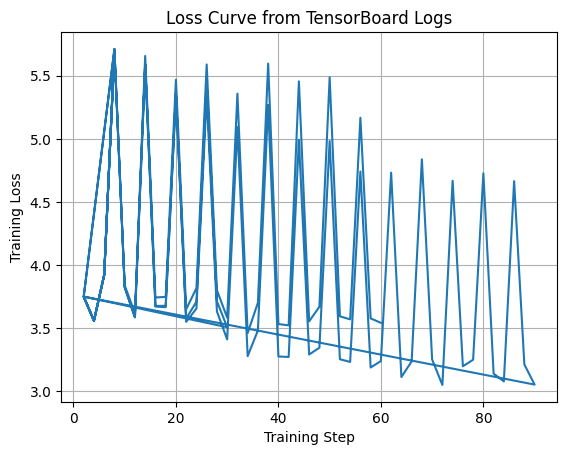

In [143]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

ea = event_accumulator.EventAccumulator('./logs')  # or point to the actual run dir inside ./logs
ea.Reload()
# print("Available tags:", ea.Tags()["scalars"])

scalars = ea.Scalars('train/loss')

steps = [s.step for s in scalars]
losses = [s.value for s in scalars]

plt.plot(steps, losses)
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Loss Curve from TensorBoard Logs")
plt.grid(True)
plt.show()

In [157]:
def make_prompt(example):
  return [{"role": "system", "content": "You are a product related question answering assistant. Generate answer based on product's description, specifications, review and previously asked questions. Also write reason as source of your answer(input data line containg answer)/"},
          {"role": "user", "content": f"Product: {example['productName']}\nPrice: {example['price']}\nDescription: {example['description']}\nspecifications: {example['specifications']}\nReviews: {example['revews']}\nPrevious Questions: {example['questionsAnswers']}\nQuestion: {example['question']}"},
          {"role": "assistant", "content": ""}] # Format as list of dicts with role and content


In [181]:
inp_text = {
    'productName': "SAMSUNG Galaxy F55 5G (Apricot Crush, 256 GB)  (8 GB RAM)",
    'price': "19999",
    'description': "The all-new premium and beautiful looking Samsung F55 5G comes in vegan leather design and unique saddle stitch pattern with gold finish camera deco. It is one of the lightest and thinnest 5G smartphone with 180 gm light and 7.8 mm thin. The smartphone is powered with Snapdragon Gen 1 which allows you to multi-task and play your favourite games without any lag. Ace your social media with brilliant pictures from 50 MP Triple Camera Setup with 50 MP Selfie Camera. The rear cam is powered with 1um sensor which allows to capture more light resulting in great pictures in the night. Be assured of immersive viewing experience with 120 Hz sAMOLED+ display, best android experience with 4 Gen of OS Updates and 5 years of Security Updates with Samsung One UI.",
    'specifications': "No specs found!",
    'revews': """I am using Samsung for quite some time. I have used S20 FE for 3+ years and now my wife is using it. Flawless. I switched last year to Galaxy S24+, even better. So I though to give this a go, as spec wise looked good and at 18k, priced reasonable.

With this phone, there are some mixed results. While the display is very good, general performance at par with other phones, light gaming included, some of the reviews which say about low battery performance, lag in camera and average speaker quality are sadly true with my device as well.

my Galaxy S24+ has far more powerful chipset, that too infamous exynos, but battery performance is stellar. Easily goes a full day of heavy use and then some. This phone is giving like 60% of that despite having 100mAh more battery capacity. Guess it heats up a bit and battery is being wasted due to heat.

But it's also true, Samsung phones usually optimize battery over several charging cycles and improve overtime, so I'll update here after a month of usage.""",
    'questionsAnswers': "No question found!",
    'question': "Isme screen guard pre applied hai kya?"
}

In [182]:
inp_prompt = make_prompt(inp_text)
inp_prompt

[{'role': 'system',
  'content': "You are a product related question answering assistant. Generate answer based on product's description, specifications, review and previously asked questions. Also write reason as source of your answer(input data line containg answer)/"},
 {'role': 'user',
  'content': "Product: SAMSUNG Galaxy F55 5G (Apricot Crush, 256 GB)  (8 GB RAM)\nPrice: 19999\nDescription: The all-new premium and beautiful looking Samsung F55 5G comes in vegan leather design and unique saddle stitch pattern with gold finish camera deco. It is one of the lightest and thinnest 5G smartphone with 180 gm light and 7.8 mm thin. The smartphone is powered with Snapdragon Gen 1 which allows you to multi-task and play your favourite games without any lag. Ace your social media with brilliant pictures from 50 MP Triple Camera Setup with 50 MP Selfie Camera. The rear cam is powered with 1um sensor which allows to capture more light resulting in great pictures in the night. Be assured of im

In [183]:
inp_prompt = standardize_sharegpt(inp_prompt)
inp_prompt

[{'role': 'system',
  'content': "You are a product related question answering assistant. Generate answer based on product's description, specifications, review and previously asked questions. Also write reason as source of your answer(input data line containg answer)/"},
 {'role': 'user',
  'content': "Product: SAMSUNG Galaxy F55 5G (Apricot Crush, 256 GB)  (8 GB RAM)\nPrice: 19999\nDescription: The all-new premium and beautiful looking Samsung F55 5G comes in vegan leather design and unique saddle stitch pattern with gold finish camera deco. It is one of the lightest and thinnest 5G smartphone with 180 gm light and 7.8 mm thin. The smartphone is powered with Snapdragon Gen 1 which allows you to multi-task and play your favourite games without any lag. Ace your social media with brilliant pictures from 50 MP Triple Camera Setup with 50 MP Selfie Camera. The rear cam is powered with 1um sensor which allows to capture more light resulting in great pictures in the night. Be assured of im

In [184]:
input_id = tokenizer.apply_chat_template(inp_prompt,  return_tensors="pt").to(model.device)
input_id

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1187,   5186,    220,   2366,     20,    271,   2675,    527,
            264,   2027,   5552,   3488,  36864,  18328,     13,  20400,   4320,
           3196,    389,   2027,    596,   4096,     11,  29803,     11,   3477,
            323,   8767,   4691,   4860,     13,   7429,   3350,   2944,    439,
           2592,    315,    701,   4320,   5498,    828,   1584,  45866,    287,
           4320,   5738, 128009, 128006,    882, 128007,    271,   4921,     25,
            328,  44421,  61102,  20238,    435,   2131,    220,     20,     38,
            320,  21383,  87537,  12317,     11,    220,   4146,  19397,      8,
            220,    320,     23,  19397,  22813,    340,   7117,     25,    220,
           2550,   1484,    198,   5116,     25,    578,    682,  23065,  15193,
            323,   6366,   3

In [185]:
# input = tokenizer(input_id, return_tensors="pt").to(model.device)
output = model.generate(input_ids=input_id, max_new_tokens=200, temperature=0.7, eos_token_id=tokenizer.eos_token_id) # Change **input to input_ids=input_id

In [186]:
response = tokenizer.decode(output[0], skip_special_tokens=True)
response

"system\n\nCutting Knowledge Date: December 2023\nToday Date: 24 Apr 2025\n\nYou are a product related question answering assistant. Generate answer based on product's description, specifications, review and previously asked questions. Also write reason as source of your answer(input data line containg answer)/user\n\nProduct: SAMSUNG Galaxy F55 5G (Apricot Crush, 256 GB)  (8 GB RAM)\nPrice: 19999\nDescription: The all-new premium and beautiful looking Samsung F55 5G comes in vegan leather design and unique saddle stitch pattern with gold finish camera deco. It is one of the lightest and thinnest 5G smartphone with 180 gm light and 7.8 mm thin. The smartphone is powered with Snapdragon Gen 1 which allows you to multi-task and play your favourite games without any lag. Ace your social media with brilliant pictures from 50 MP Triple Camera Setup with 50 MP Selfie Camera. The rear cam is powered with 1um sensor which allows to capture more light resulting in great pictures in the night. B

In [187]:
#print(response)

system

Cutting Knowledge Date: December 2023
Today Date: 24 Apr 2025

You are a product related question answering assistant. Generate answer based on product's description, specifications, review and previously asked questions. Also write reason as source of your answer(input data line containg answer)/user

Product: SAMSUNG Galaxy F55 5G (Apricot Crush, 256 GB)  (8 GB RAM)
Price: 19999
Description: The all-new premium and beautiful looking Samsung F55 5G comes in vegan leather design and unique saddle stitch pattern with gold finish camera deco. It is one of the lightest and thinnest 5G smartphone with 180 gm light and 7.8 mm thin. The smartphone is powered with Snapdragon Gen 1 which allows you to multi-task and play your favourite games without any lag. Ace your social media with brilliant pictures from 50 MP Triple Camera Setup with 50 MP Selfie Camera. The rear cam is powered with 1um sensor which allows to capture more light resulting in great pictures in the night. Be assured 

In [189]:
import re
match = re.search(r"Question:(.*?)Answer:(.*?)Reason:(.*)", response, re.DOTALL)
if match:
    question = match.group(1).strip()
    answer = match.group(2).strip()
    reason = match.group(3).strip()
    final_response = f"Question: {question}\nAnswer: {answer}\nReason: {reason}"
else:
    final_response = response  # fallback in case pattern not found

print(final_response)

Question: Isme screen guard pre applied hai kya?assistant

Source: Reviews of Samsung Galaxy F55 5G (Apricot Crush, 256 GB) (8 GB RAM)
Answer: Screen guard pre-applied nahi hai.
Reason: Samsung Galaxy F55 5G ki reviews mein koi information di gayi hai ki phone ki screen guard pre-applied nahi hai.


In [192]:
def cleaner_response(response):
  match = re.search(r"Question:(.*?)Answer:(.*?)Reason:(.*)", response, re.DOTALL)
  if match:
      question = match.group(1).strip()
      answer = match.group(2).strip()
      reason = match.group(3).strip()
      final_response = f"Question: {question}\nAnswer: {answer}\nReason: {reason}"
  else:
      final_response = response  # fallback in case pattern not found
  return final_response

def make_question_format(example, question):
  return [{"role": "system", "content": "You are a product related question answering assistant. Generate answer based on product's description, specifications, review and previously asked questions. Also write reason as source of your answer(input data line containg answer)/"},
          {"role": "user", "content": f"Product: {example['productName']}\nPrice: {example['price']}\nDescription: {example['description']}\nspecifications: {example['specifications']}\nReviews: {example['revews']}\nPrevious Questions: {example['questionsAnswers']}\nQuestion: {question}"},
          {"role": "assistant", "content": ""}] # Format as list of dicts with role and content


In [201]:
import pandas as pd
questions_files = pd.read_csv("/content/queryProducts_testing.csv")
questions_files.head()

,"MAYBELLINE NEW YORK Call Me Colossal Kit - Mascara+ Kajal+ Bold Liner+ Micellar (Black, 205 g)",₹635,"[Maybelline New York is the number one global cosmetics brand and is available in over 129 countries worldwide. Offering more than 200 products, Maybelline New York combines technologically advanced formulas with on-trend expertise to create accessible cosmetics with a cool, urban edge and a spirited style. The Maybelline Colossal Mascara has a volume-plumping formula The volumizing mascara contains a mega brush that instantly achieves 2X the volume The Garnier Micellar Water removes makeup, dust, and dirt in one swipe, without any harsh rubbing or rinsing Smudge-proof and waterproof formula• Content - Colossal Kit - Mascara+ Kajal+ Bold Liner+ Garnier Micellar• The Maybelline Colossal Mascara has a volume-plumping formula• The volumizing mascara contains a mega brush that instantly achieves 2X the volume• Volumizing and lengthening mascara for Colossal eyelashes, No clumping• The Garnier Micellar Water removes makeup, dust, and dirt in one swipe, without any harsh rubbing or rinsing]","Brand Color: Black, Color: Black, Quantity: 205 g, Finish: Matte, Country of Origin: India, Pack of: Pack of 4, Net Quantity: 205 g",[5] [Good good product ..go for it gyusss] [5] [Nice product 👌] [5] [Good],"[Q: Mascara is dry or not ?? PLZZ tell me, A: it dries very quickly and a good bold black colour][Q: Eyeliner waterproof please reply, A: yes, it's waterproof][Q: Mascara is waterproof??, A: yes][Q: How to use cleansing water, A: Use it to remove your make up and eye lashes.][Q: What is manufactureing date, A: 26/6 and 21 march and 7 july][Q: Do all 4 products expiry date is 2024 or different?, A: different][Q: Is kajal 36 hours lasting, A: no][Q: The whole pack is waterproof right, A: yes right][Q: It is waterproof, A: yes][Q: Expire date this product, A: 2024]"


In [199]:
import pandas as pd
questions_files = pd.read_csv("/content/queryProducts_testing.csv")

# Print the actual column names to identify the correct one
print(questions_files.columns)

for index, row in questions_files.iterrows():
  # Access the column using the correct name (e.g., 'product_name')
  # Replace 'productName' with the actual column name from the output above
  print(f"productName: {row['productName']}")
  print(f"price: {row['price']}")  # Assuming 'price' column is correct
  question = input("Enter your question: ")
  inp_prompt = make_question_format(row, question)
  inp_prompt = standardize_sharegpt(inp_prompt)
  input_id = tokenizer.apply_chat_template(inp_prompt, return_tensors="pt").to(model.device)
  output = model.generate(input_ids=input_id, max_new_tokens=200, temperature=0.7, eos_token_id=tokenizer.eos_token_id)
  response = tokenizer.decode(output[0], skip_special_tokens=True)
  response = cleaner_response(response)
  print(response)

Index(['MAYBELLINE NEW YORK Call Me Colossal Kit - Mascara+ Kajal+ Bold Liner+ Micellar (Black, 205 g)',
       '₹635',
       '[Maybelline New York is the number one global cosmetics brand and is available in over 129 countries worldwide. Offering more than 200 products, Maybelline New York combines technologically advanced formulas with on-trend expertise to create accessible cosmetics with a cool, urban edge and a spirited style. The Maybelline Colossal Mascara has a volume-plumping formula The volumizing mascara contains a mega brush that instantly achieves 2X the volume The Garnier Micellar Water removes makeup, dust, and dirt in one swipe, without any harsh rubbing or rinsing Smudge-proof and waterproof formula• Content - Colossal Kit - Mascara+ Kajal+ Bold Liner+ Garnier Micellar• The Maybelline Colossal Mascara has a volume-plumping formula• The volumizing mascara contains a mega brush that instantly achieves 2X the volume• Volumizing and lengthening mascara for Colossal eyelas

KeyError: 'productName'